In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, select, join
from scipy import stats as st

In [2]:
# Create engine
# Note: User will need to supply their own PostgreSQL password under variable below
user = 'postgres'
host = 'localhost'
password = 'postgres-2002'
port = '5432'
db = 'avg_aqi'
uri = f'postgresql://{user}:{password}@{host}:{port}/{db}'
uri
engine = create_engine(uri)

In [18]:
df = pd.DataFrame(pd.read_sql_table('aqi_2019_2020', engine))
df

,state,county,county_code,date,aqi,category,defining_parameter,number_sites,month_day
0,Alabama,Baldwin,3,2019-01-03,18,Good,PM2.5,1,01-03
1,Alabama,Baldwin,3,2019-01-06,35,Good,PM2.5,1,01-06
2,Alabama,Baldwin,3,2019-01-09,14,Good,PM2.5,1,01-09
3,Alabama,Baldwin,3,2019-01-12,36,Good,PM2.5,1,01-12
4,Alabama,Baldwin,3,2019-01-15,38,Good,PM2.5,1,01-15
...,...,...,...,...,...,...,...,...,...
381414,Wyoming,Uinta,41,2020-03-27,5,Good,PM10,2,03-27
381415,Wyoming,Uinta,41,2020-03-28,6,Good,PM10,2,03-28
381416,Wyoming,Uinta,41,2020-03-29,6,Good,PM10,2,03-29
381417,Wyoming,Uinta,41,2020-03-30,5,Good,PM10,2,03-30


In [19]:
df = df.dropna(how='any')

In [62]:
df_2019 = pd.DataFrame(df.loc[(df.date <= '2019-05-13')].groupby(['county_code'])['aqi'].mean())
df_2020 = pd.DataFrame(df.loc[df.date >= '2020-01-1'].groupby(['county_code'])['aqi'].mean())
df2 = pd.merge(df_2019,df_2020,how='inner',on=['county_code'], suffixes=('_2019', '_2020'))
df2

,aqi_2019,aqi_2020
county_code,,
1,35.548936,24.185149
3,39.394604,32.827298
5,38.318825,37.423848
7,37.473175,32.420857
9,36.291825,24.592079
...,...,...
710,21.796992,20.473684
760,36.255639,23.529412
775,24.116279,24.615385


In [63]:
ttest,pval = st.ttest_ind(df2.aqi_2019,df2.aqi_2020,equal_var=False)
print("p-value",pval)
if pval <0.5:
  print("we reject null hypothesis")
else:
  print("we accept null hypothesis")

p-value 2.2823794611182522e-10
we reject null hypothesis


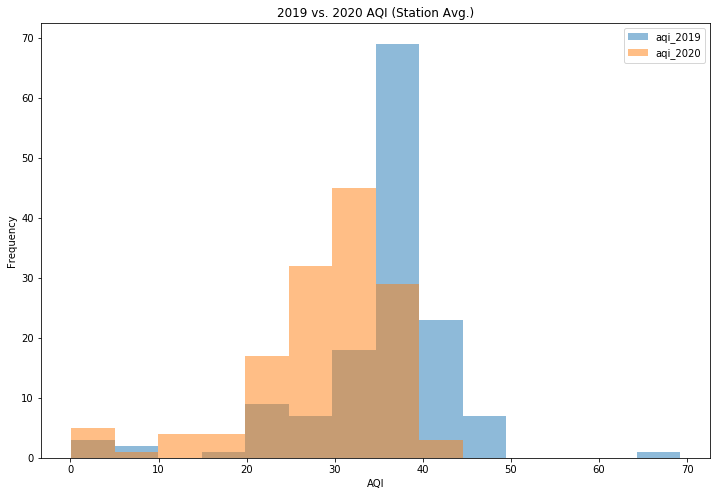

In [64]:
df2.plot(kind='hist', bins=14, alpha=.5, figsize=(12,8), title=('2019 vs. 2020 AQI (Station Avg.)'))
plt.xlabel('AQI')
plt.savefig('../01_Resources/Images/station_hist.png')

R2: 0.7937650440289038
P-value: 1.3506394106332055e-31


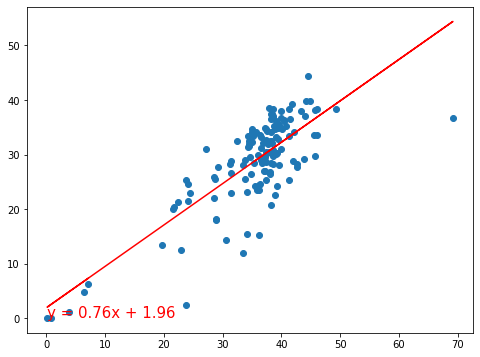

In [44]:
df2 = df2.reset_index()
# df2 = df2.loc[df2.month_day > '03-01']

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(df2.aqi_2019,df2.aqi_2020)
x = np.asarray(df2.aqi_2019, dtype=np.float64)
regress_values = x * slope + intercept

# Plots scatter plot and regresion
plt.figure(figsize=(8, 6))
plt.scatter(df2.aqi_2019,df2.aqi_2020)
plt.plot(x,regress_values,"r-")

# Annotates graph with equation
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.annotate(line_eq,xy=(min(x),min(df2.aqi_2020)),fontsize=15,color="red")
print(f'R2: {rvalue}')
print(f'P-value: {pvalue}')

In [12]:
df_2019 = pd.DataFrame(df.loc[(df.date >= '2019-02-15') & (df.date <= '2019-05-13')].groupby(['month_day'])['aqi'].mean())
df_2020 = pd.DataFrame(df.loc[df.date >= '2020-02-15'].groupby(['month_day'])['aqi'].mean())
df_2019

,aqi
month_day,
02-15,34.786396
02-16,32.367542
02-17,31.320086
02-18,31.963095
02-19,34.553039
...,...
05-09,33.700680
05-10,33.752341
05-11,33.433194


In [13]:
# df_2020 = df_2020.drop(columns=['number_sites'])
# df_2019 = df_2019.drop(columns=['number_sites'])
df_2020

,aqi
month_day,
02-15,31.610548
02-16,34.513514
02-17,35.570470
02-18,33.221992
02-19,29.690583
...,...
05-09,44.000000
05-10,47.000000
05-11,42.000000


In [14]:
df2 = pd.merge(df_2019,df_2020,how='inner',on='month_day', suffixes=('_2019', '_2020'))
df2

,aqi_2019,aqi_2020
month_day,,
02-15,34.786396,31.610548
02-16,32.367542,34.513514
02-17,31.320086,35.570470
02-18,31.963095,33.221992
02-19,34.553039,29.690583
...,...,...
05-09,33.700680,44.000000
05-10,33.752341,47.000000
05-11,33.433194,42.000000


In [15]:
ttest,pval = st.ttest_ind(df2.aqi_2019,df2.aqi_2020,equal_var=False)
print("p-value",pval)
if pval <0.5:
  print("we reject null hypothesis")
else:
  print("we accept null hypothesis")

p-value 1.3144521906895813e-05
we reject null hypothesis


R2: -0.15760014702446232
P-value: 0.14252219186889972


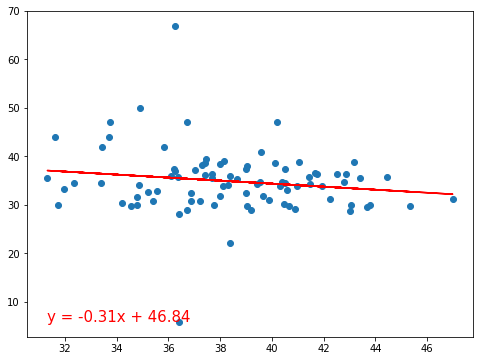

In [17]:
df2 = df2.reset_index()
# df2 = df2.loc[df2.month_day > '03-01']

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(df2.aqi_2019,df2.aqi_2020)
x = np.asarray(df2.aqi_2019, dtype=np.float64)
regress_values = x * slope + intercept

# Plots scatter plot and regresion
plt.figure(figsize=(8, 6))
plt.scatter(df2.aqi_2019,df2.aqi_2020)
plt.plot(x,regress_values,"r-")

# Annotates graph with equation
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.annotate(line_eq,xy=(min(x),min(df2.aqi_2020)),fontsize=15,color="red")
print(f'R2: {rvalue}')
print(f'P-value: {pvalue}')

In [252]:
df2 = df.groupby('date')[['aqi','five_year_avg']].mean()
df2

,aqi,five_year_avg
date,,
2020-01-01,29.987387,35.688072
2020-01-02,28.420319,34.775329
2020-01-03,28.983968,35.147460
2020-01-04,28.336283,32.491931
2020-01-05,26.200000,34.115203
...,...,...
2020-05-09,44.000000,46.857143
2020-05-10,47.000000,45.550000
2020-05-11,42.000000,45.100000


In [254]:
ttest,pval = st.ttest_rel(df2.aqi,df2.five_year_avg)
print("p-value",pval)
if pval <0.5:
  print("we reject null hypothesis")
else:
  print("we accept null hypothesis")

p-value 2.421775465499343e-22
we reject null hypothesis


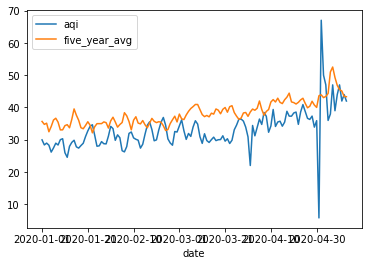

In [256]:
df2.plot(kind='line')

# Mobility data

In [211]:
mobility_uri = f"postgresql://{user}:{password}@{host}:{port}/COVID_Mobility"
mobility_uri
engine = create_engine(mobility_uri)

In [212]:
df_mobility = pd.DataFrame(pd.read_sql_table('apple_google_mobility', engine))
df_mobility

,country,dates,apple_mobility_percent,google_mobility_percent
0,Argentina,2020-02-15,115.54,99.67
1,Argentina,2020-02-16,78.66,95.00
2,Argentina,2020-02-17,92.85,94.17
3,Argentina,2020-02-18,104.82,103.50
4,Argentina,2020-02-19,102.99,104.67
...,...,...,...,...
13674,Vietnam,2020-07-23,119.86,94.33
13675,Vietnam,2020-07-24,134.24,97.33
13676,Vietnam,2020-07-25,143.74,100.50
13677,Vietnam,2020-07-26,119.50,98.83


In [213]:
us_mobility = df_mobility.loc[df_mobility.country=='United States']
us_mobility

,country,dates,apple_mobility_percent,google_mobility_percent
13023,United States,2020-02-15,132.94,104.50
13024,United States,2020-02-16,103.39,104.17
13025,United States,2020-02-17,106.68,101.00
13026,United States,2020-02-18,104.78,101.17
13027,United States,2020-02-19,106.41,102.00
...,...,...,...,...
13182,United States,2020-07-23,103.86,97.00
13183,United States,2020-07-24,117.63,96.33
13184,United States,2020-07-25,117.42,104.33
13185,United States,2020-07-26,93.15,101.00


In [214]:
us_mobility['avg'] = (us_mobility.apple_mobility_percent+us_mobility.google_mobility_percent)/2
us_mobility

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,country,dates,apple_mobility_percent,google_mobility_percent,avg
13023,United States,2020-02-15,132.94,104.50,118.720
13024,United States,2020-02-16,103.39,104.17,103.780
13025,United States,2020-02-17,106.68,101.00,103.840
13026,United States,2020-02-18,104.78,101.17,102.975
13027,United States,2020-02-19,106.41,102.00,104.205
...,...,...,...,...,...
13182,United States,2020-07-23,103.86,97.00,100.430
13183,United States,2020-07-24,117.63,96.33,106.980
13184,United States,2020-07-25,117.42,104.33,110.875
13185,United States,2020-07-26,93.15,101.00,97.075


In [215]:
us_mobility = us_mobility.loc[us_mobility.dates <= '2020-05-13']
us_mobility

,country,dates,apple_mobility_percent,google_mobility_percent,avg
13023,United States,2020-02-15,132.94,104.50,118.720
13024,United States,2020-02-16,103.39,104.17,103.780
13025,United States,2020-02-17,106.68,101.00,103.840
13026,United States,2020-02-18,104.78,101.17,102.975
13027,United States,2020-02-19,106.41,102.00,104.205
...,...,...,...,...,...
13107,United States,2020-05-09,65.84,89.00,77.420
13108,United States,2020-05-10,50.31,86.67,68.490
13109,United States,2020-05-11,NaN,80.83,NaN
13110,United States,2020-05-12,NaN,84.67,NaN


In [216]:
us_mobility['month_day'] = us_mobility.dates.str.replace('2020-', '')
us_mobility 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,country,dates,apple_mobility_percent,google_mobility_percent,avg,month_day
13023,United States,2020-02-15,132.94,104.50,118.720,02-15
13024,United States,2020-02-16,103.39,104.17,103.780,02-16
13025,United States,2020-02-17,106.68,101.00,103.840,02-17
13026,United States,2020-02-18,104.78,101.17,102.975,02-18
13027,United States,2020-02-19,106.41,102.00,104.205,02-19
...,...,...,...,...,...,...
13107,United States,2020-05-09,65.84,89.00,77.420,05-09
13108,United States,2020-05-10,50.31,86.67,68.490,05-10
13109,United States,2020-05-11,NaN,80.83,NaN,05-11
13110,United States,2020-05-12,NaN,84.67,NaN,05-12


In [217]:
us_mobility = us_mobility[['month_day','avg']]
us_mobility

,month_day,avg
13023,02-15,118.720
13024,02-16,103.780
13025,02-17,103.840
13026,02-18,102.975
13027,02-19,104.205
...,...,...
13107,05-09,77.420
13108,05-10,68.490
13109,05-11,NaN
13110,05-12,NaN


In [218]:
us_mobility = us_mobility.dropna(how='any')
us_mobility = us_mobility.set_index('month_day')
us_mobility

,avg
month_day,
02-15,118.720
02-16,103.780
02-17,103.840
02-18,102.975
02-19,104.205
...,...
05-07,74.145
05-08,74.285
05-09,77.420


In [219]:
merged2 = pd.merge(df2,us_mobility,on='month_day',how='inner')
merged2

,aqi_2019,aqi_2020,avg
month_day,,,
02-15,34.786396,31.610548,118.720
02-16,32.367542,34.513514,103.780
02-17,31.320086,35.570470,103.840
02-18,31.963095,33.221992,102.975
02-19,34.553039,29.690583,104.205
...,...,...,...
05-07,40.200837,47.000000,74.145
05-08,38.134515,39.000000,74.285
05-09,33.700680,44.000000,77.420


In [220]:
ttest,pval = st.ttest_ind(merged2.avg, merged2.aqi_2020)
print("p-value",pval)
if pval <0.5:
  print("we reject null hypothesis")
else:
  print("we accept null hypothesis")

p-value 3.1150929748089664e-41
we reject null hypothesis


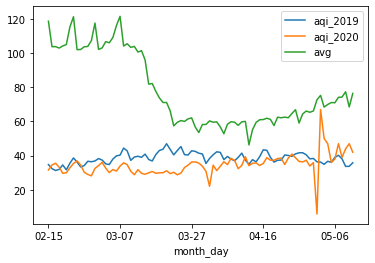

In [221]:
merged2.plot(kind='line')

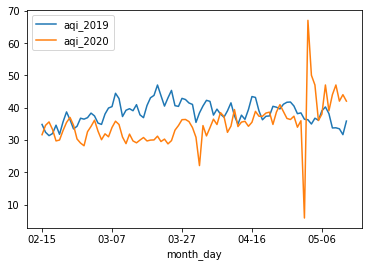

In [202]:
df2.plot(kind='line')

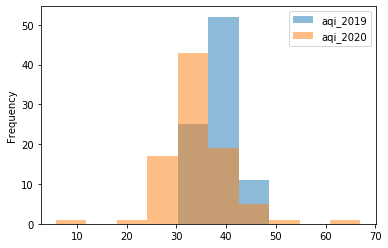

In [209]:
df2.plot(kind='hist', alpha=.5)

In [205]:
ttest,pval = st.ttest_rel(df2.aqi_2019,df2.aqi_2020)
print("p-value",pval)
if pval <0.5:
  print("we reject null hypothesis")
else:
  print("we accept null hypothesis")

p-value 4.969058396143688e-05
we reject null hypothesis


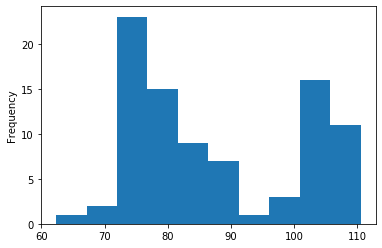

In [207]:
merged2.google_mobility_percent.plot(kind='hist')

R2: -0.19269645933462792
P-value: 0.07547880909558535


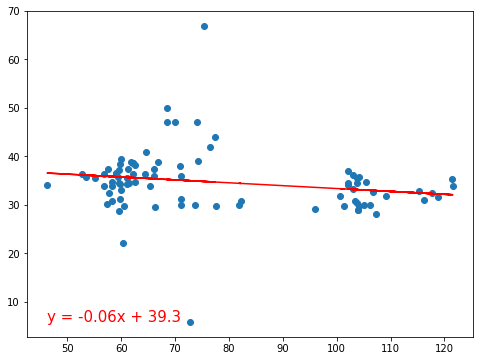

In [259]:
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(merged2.avg,merged2.aqi_2020)
x = np.asarray(merged2.avg, dtype=np.float64)
regress_values = x * slope + intercept

# Plots scatter plot and regresion
plt.figure(figsize=(8, 6))
plt.scatter(merged2.avg,merged2.aqi_2020)
plt.plot(x,regress_values,"r-")

# Annotates graph with equation
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.annotate(line_eq,xy=(min(x),min(merged2.aqi_2020)),fontsize=15,color="red")
print(f'R2: {rvalue}')
print(f'P-value: {pvalue}')

R2: -0.13421924304153593
P-value: 0.2644498139016476


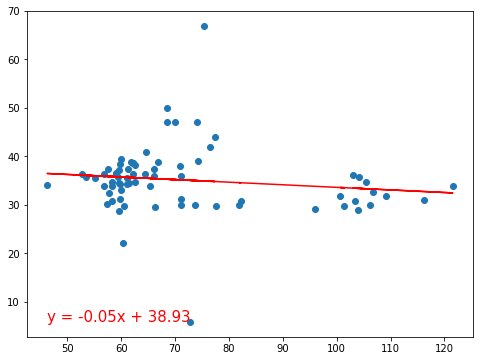

In [260]:
merged3 = merged2.reset_index()
merged3 = merged3.loc[merged3.month_day > '03-01']

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(merged3.avg,merged3.aqi_2020)
x = np.asarray(merged3.avg, dtype=np.float64)
regress_values = x * slope + intercept

# Plots scatter plot and regresion
plt.figure(figsize=(8, 6))
plt.scatter(merged3.avg,merged3.aqi_2020)
plt.plot(x,regress_values,"r-")

# Annotates graph with equation
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.annotate(line_eq,xy=(min(x),min(merged3.aqi_2020)),fontsize=15,color="red")
print(f'R2: {rvalue}')
print(f'P-value: {pvalue}')

In [238]:
merged3

,month_day,aqi_2019,aqi_2020,avg
15,03-02,37.414995,36.095679,103.080
16,03-03,35.199364,32.700617,106.750
17,03-04,34.800589,30.064246,106.110
18,03-05,38.003178,31.879257,109.160
19,03-06,39.868783,30.965732,116.150
...,...,...,...,...
81,05-07,40.200837,47.000000,74.145
82,05-08,38.134515,39.000000,74.285
83,05-09,33.700680,44.000000,77.420
84,05-10,33.752341,47.000000,68.490
